# 8) Functional Connectivity Matrix Sorting and Visualization
This section contains code to sort functional connectivity matrices based on hierarchical clustering and visualize the modular structure of the brain.

In [ ]:
# General analysis
import numpy as np
import pandas as pd

# For hierarchical clustering and distance calculations
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.cluster import adjusted_rand_score

# For plotting and visualizations
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.cm import get_cmap

# For saving files and plots
import os

# For neuroimaging visualizations
from nilearn.plotting import plot_markers
from nilearn import plotting

# Suppress warnings to keep the notebook clean
import warnings
warnings.filterwarnings("ignore")

## ConnectivityMatrixPlotter Class
The ConnectivityMatrixPlotter class is designed to visualize and compare brain connectivity matrices, specifically focusing on both functional connectivity (FC) and structural connectivity (SC) data. It sorts and clusters the connectivity matrices, binarizes the structural connectivity matrices, and then plots the results with annotated modules.

### Features:
1) Matrix Sorting and Clustering:
* Sorts both the functional connectivity matrices (rsFC and avg_rsFC) by clustering, dividing them into num_modules clusters (default is 20).
* Binarizes the structural connectivity matrices (SC and avg_SC) using a threshold of 0.1.
* Reorders matrices based on the clustering results for better visualization of modular structures.

2) Plotting:
* Plots the sorted and binarized connectivity matrices in a 2x2 subplot layout.
* Each plot shows a matrix with annotations for the identified modules, drawn as boxes, and labeled by module numbers.
* Colorbars are added to provide context for the correlation values in functional connectivity plots.

3) Customization:
* Users can select the clustering method (default is 'weighted') and the number of modules (default is 20).
* The functional connectivity matrices can be plotted with varying colormap and value ranges for better clarity.

### Parameters:
* rsFC: Functional connectivity matrix (raw).
* avg_rsFC: Average functional connectivity matrix.
* SC: Structural connectivity matrix.
* avg_SC: Average structural connectivity matrix.
* num_modules: Number of modules for clustering (default is 20).
* method: Clustering method to be used for sorting the matrices (default is 'weighted').

### Usage Example:
plotter = ConnectivityMatrixPlotter(rsFC, avg_rsFC, SC, avg_SC)
plotter.plot_all()

### Key Methods:
* _cluster_and_sort: Sorts a given matrix by clustering it into num_modules clusters using hierarchical clustering.
* _prepare_sorted_matrices: Prepares all matrices by sorting functional matrices and binarizing structural matrices.
* _plot_matrix_with_modules: Helper function to plot a matrix with module boxes and labels.
* plot_all: Plots all the matrices (sorted and binarized) in a 2x2 subplot.

### Plots:
1) Functional Connectivity Matrices:
* Visualizes the raw (rsFC) and average (avg_rsFC) matrices, sorted by clustering and color-mapped with correlation values.

2) Binarized Structural Connectivity Matrices:
* Visualizes the binarized (SC and avg_SC) matrices, reordered according to the functional connectivity matrix clustering.

This class is useful for researchers working with brain connectivity data, as it helps visualize and interpret complex patterns in functional and structural relationships across brain modules.

In [9]:
class ConnectivityMatrixPlotter:
    
    def __init__(self, rsFC, avg_rsFC, SC, avg_SC, num_modules=20, method='weighted'):
        self.rsFC = rsFC
        self.avg_FC = avg_rsFC
        self.SC = SC
        self.avg_SC = avg_SC
        self.num_modules = num_modules
        self.method = method
        self._prepare_sorted_matrices()

    def _cluster_and_sort(self, matrix):
        Y = pdist(matrix, metric='cosine')
        Z = linkage(Y, method=self.method)
        labels = fcluster(Z, t=self.num_modules, criterion='maxclust')
        sorted_indices = np.argsort(labels)
        sorted_matrix = matrix[np.ix_(sorted_indices, sorted_indices)]
        sorted_labels = labels[sorted_indices]
        return sorted_matrix, sorted_labels, sorted_indices, labels

    def _prepare_sorted_matrices(self):
        # Sort rsFC
        self.sorted_rsFC, self.sorted_labels_rsFC, self.sorted_indices_rsFC, _ = self._cluster_and_sort(self.rsFC)
        # Sort avg_FC
        self.sorted_avgFC, self.sorted_labels_avgFC, self.sorted_indices_avgFC, _ = self._cluster_and_sort(self.avg_FC)
        # Binarize and reorder SC
        self.binarized_SC = (self.SC > 0.1).astype(int)
        self.sorted_SC = self.binarized_SC[np.ix_(self.sorted_indices_rsFC, self.sorted_indices_rsFC)]
        # Binarize and reorder avg SC
        self.binarized_avg_SC = (self.avg_SC > 0.1).astype(int)
        self.sorted_avg_SC = self.binarized_avg_SC[np.ix_(self.sorted_indices_avgFC, self.sorted_indices_avgFC)]

    def _plot_matrix_with_modules(self, ax, matrix, labels, title, vmin=-0.4, vmax=0.8, cmap='jet', text_color='black'):
        unique_modules, counts = np.unique(labels, return_counts=True)
        im = ax.imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='none')

        # Draw module boxes
        start = 0
        for idx, size in enumerate(counts):
            end = start + size
            ax.plot([start, end], [start, start], color='black', linewidth=1)
            ax.plot([start, end], [end, end], color='black', linewidth=1)
            ax.plot([start, start], [start, end], color='black', linewidth=1)
            ax.plot([end, end], [start, end], color='black', linewidth=1)
            mid = (start + end) / 2
            ax.text(mid, mid, str(idx + 1), color=text_color, fontsize=10,
                    ha='center', va='center', fontweight='bold')
            start = end

        # Axes ticks
        tick_positions = [t for t in [500, 1000, 1500, 2000, 2500] if t < matrix.shape[0]]
        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)
        ax.set_xticklabels([str(t) for t in tick_positions])
        ax.set_yticklabels([str(t) for t in tick_positions])
        ax.set_xlim(0, matrix.shape[0])
        ax.set_ylim(matrix.shape[0], 0)
        ax.set_title(title)
        return im

    def plot_all(self, save_path=None):
        fig, axs = plt.subplots(2, 2, figsize=(18, 12))

        # Left: colored FC matrices
        im1 = self._plot_matrix_with_modules(
            axs[0, 0], self.sorted_rsFC, self.sorted_labels_rsFC, 
            "rsFC Matrix - 20 Modules", vmin=-0.4, vmax=0.8, cmap='jet', text_color='black'
        )
        im2 = self._plot_matrix_with_modules(
            axs[1, 0], self.sorted_avgFC, self.sorted_labels_avgFC, 
            "avg_rsFC Matrix - 20 Modules", vmin=-0.4, vmax=0.8, cmap='jet', text_color='black'
        )

        # Right: binarized SC matrices
        self._plot_matrix_with_modules(
            axs[0, 1], self.sorted_SC, self.sorted_labels_rsFC, 
            "SC Matrix (Binarized, reordered by rsFC modules)", vmin=0, vmax=1, cmap='binary', text_color='blue'
        )
        self._plot_matrix_with_modules(
            axs[1, 1], self.sorted_avg_SC, self.sorted_labels_avgFC, 
            "avg_SC Matrix (Binarized, reordered by avg rsFC modules)", vmin=0, vmax=1, cmap='binary', text_color='blue'
        )

        # Colorbar
        cbar_ax = fig.add_axes([0.93, 0.12, 0.015, 0.75])
        cbar = fig.colorbar(im2, cax=cbar_ax)
        cbar.set_label("Correlation", rotation=270, labelpad=15)
        cbar.set_ticks([-0.4, 0.0, 0.8])
        cbar.ax.set_yticklabels(['-0.4', '0.0', '0.8'])

        plt.tight_layout(rect=[0, 0, 0.92, 1])
        if save_path is not None:
            fig.savefig(save_path)
            print(f"Plot saved to {save_path}")
        plt.show()
        plt.close()

In [3]:
loaded_data = np.load('npz_files/matrices.npz')
rsFC_matrix = loaded_data['rsFC']
avg_rsFC_matrix = loaded_data['avg_rsFC']
SC_matrix = loaded_data['SC']
avg_SC_matrix = loaded_data['avg_SC']

In [10]:
a = ConnectivityMatrixPlotter(rsFC= rsFC_matrix, avg_rsFC= avg_rsFC_matrix, SC= SC_matrix, avg_SC= avg_SC_matrix)

Plot saved to plot_files/connectivity_matrices.png


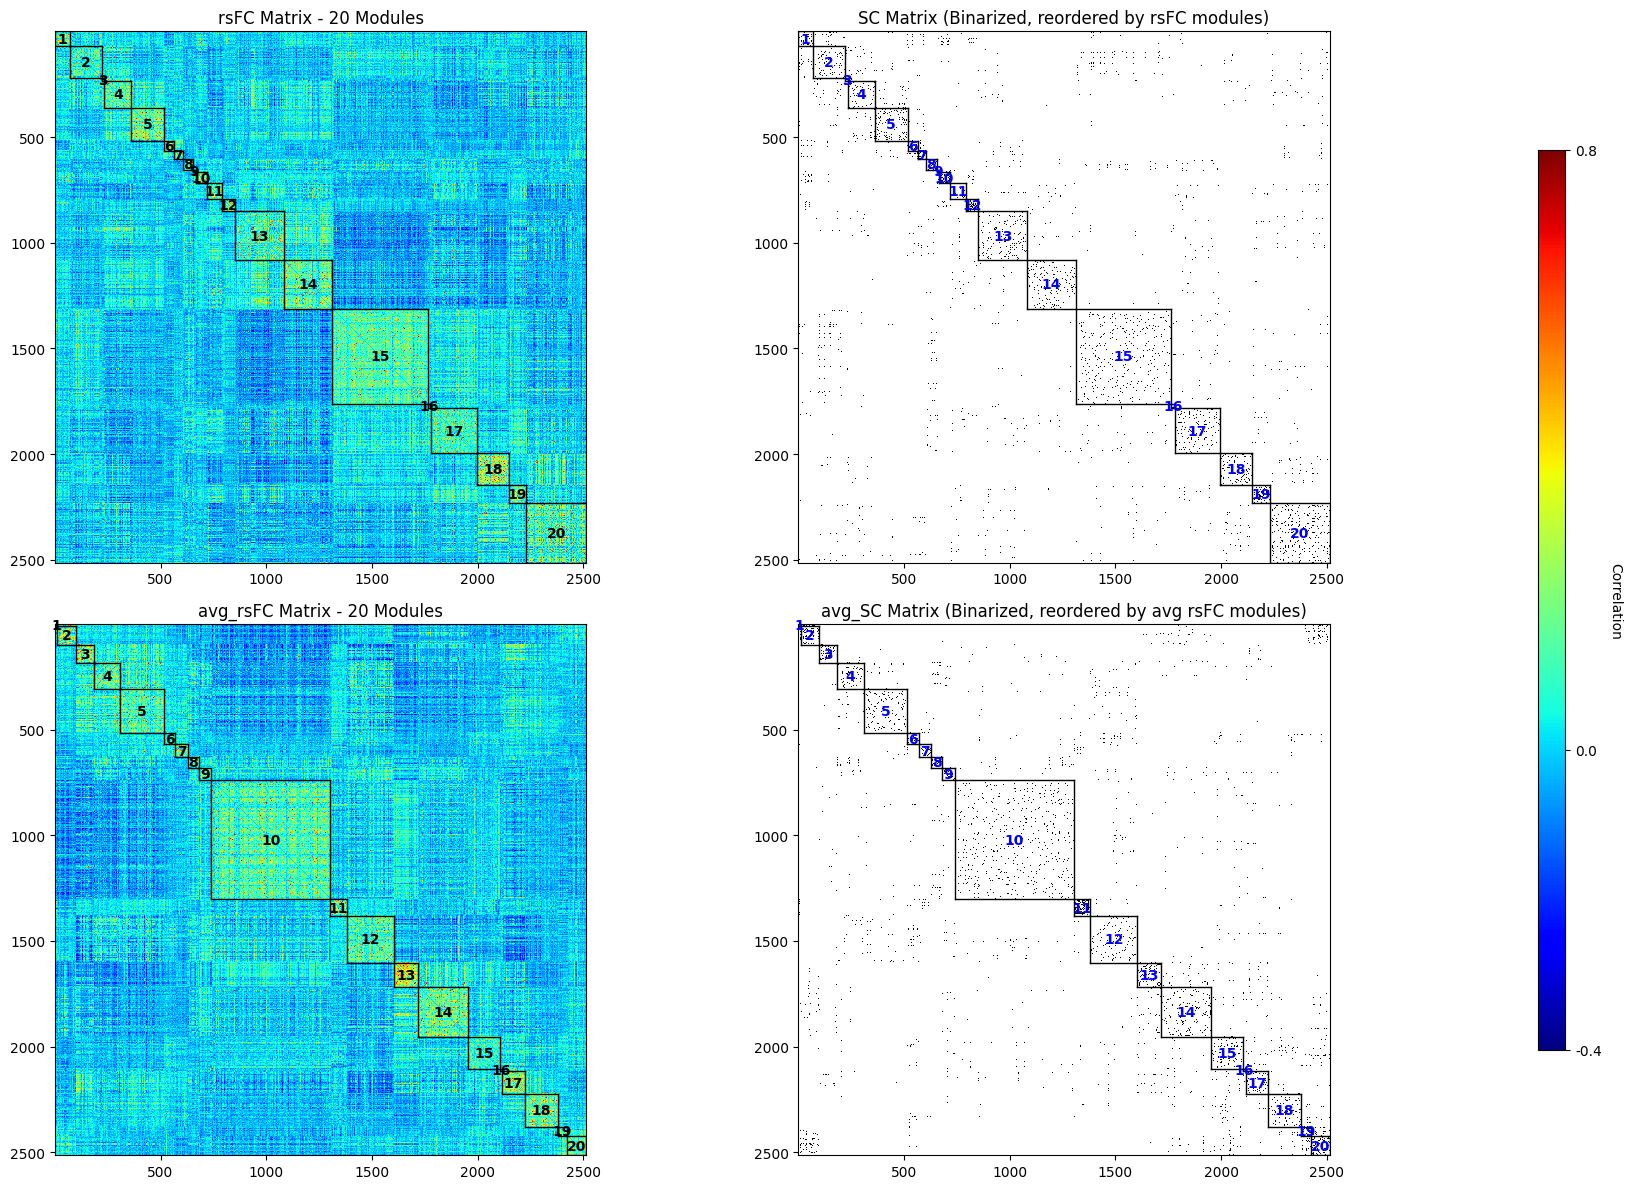

In [11]:
a.plot_all(save_path='plot_files/connectivity_matrices.png')

Although the matrices are quite similar, we can observe how differently the modules can emerge here. For example, despite the similarities between the rsFC and avg_rsFC matrices, their sorted versions reveal different module arrangements.

In [12]:
sorted_SC_matrix, sorted_SC_labels, _, SC_labels = a._cluster_and_sort(SC_matrix)
sorted_avgSC_matrix, sorted_avgSC_labels, _, avgSC_labels = a._cluster_and_sort(avg_SC_matrix)
sorted_rsFC_matrix, sorted_rsFC_labels, _, rsFC_labels = a._cluster_and_sort(rsFC_matrix)
sorted_avgrsFC_matrix, sorted_avgrsFC_labels, _, avgrsFC_labels = a._cluster_and_sort(avg_rsFC_matrix)

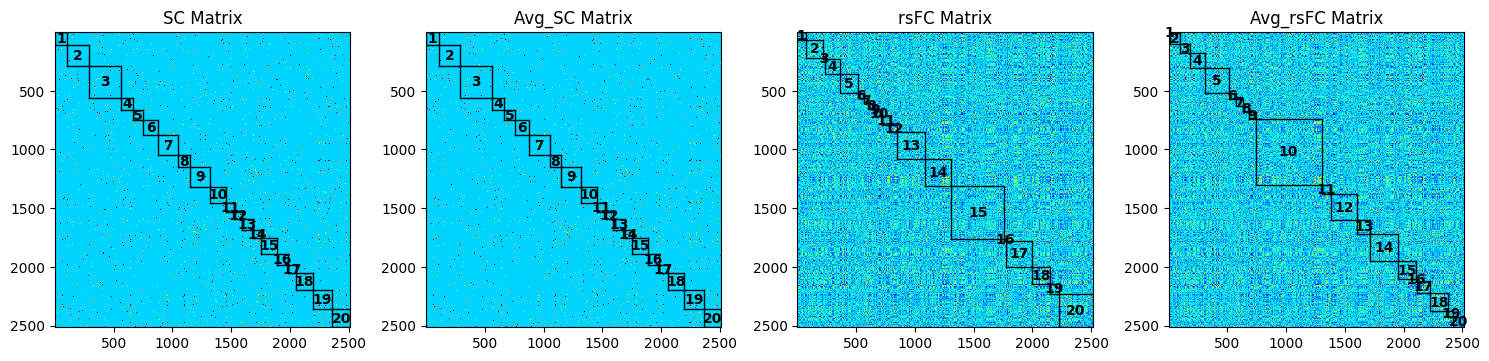

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

# First matrix
a._plot_matrix_with_modules(matrix=SC_matrix, labels=SC_labels, title="SC Matrix", ax=axes[0])

# Second matrix
a._plot_matrix_with_modules(matrix=avg_SC_matrix, labels=avgSC_labels, title="Avg_SC Matrix", ax=axes[1])

# Third matrix
a._plot_matrix_with_modules(matrix=rsFC_matrix, labels=rsFC_labels, title="rsFC Matrix", ax=axes[2])

# Fourth matrix
a._plot_matrix_with_modules(matrix=avg_rsFC_matrix, labels=avgrsFC_labels, title="Avg_rsFC Matrix", ax=axes[3])

plt.tight_layout()
plt.show()

As we can see in the figure, the structural connectivity (SC) matrices are identical, indicating high reproducibility of the structural connectivity data. However, the functional connectivity (rsFC) matrices show some differences.

# 9) Dendrogram

Dendrogram plot saved as 'plot_files\dendrograms.png'


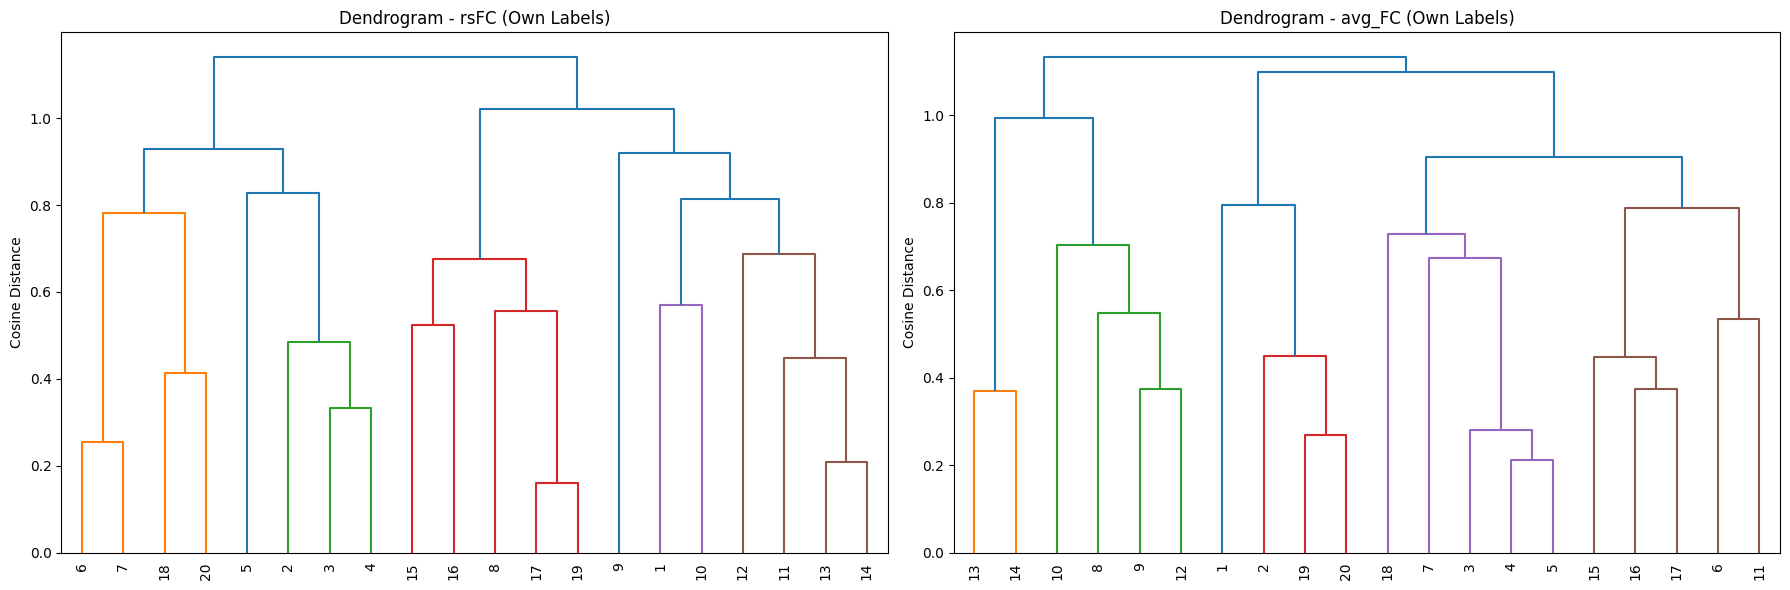

In [ ]:
output_dir = 'plot_files'
os.makedirs(output_dir, exist_ok=True)

def compute_module_means(matrix, module_labels, n_modules=20):
    module_means = np.zeros((n_modules, n_modules))
    for i in range(1, n_modules + 1):
        idx_i = np.where(module_labels == i)[0]
        for j in range(1, n_modules + 1):
            idx_j = np.where(module_labels == j)[0]
            submatrix = matrix[np.ix_(idx_i, idx_j)]
            module_means[i-1, j-1] = np.mean(submatrix)
    return module_means

def plot_dendrogram(ax, module_means, title):
    Y = pdist(module_means, metric='cosine')
    Z = linkage(Y, method='average')
    dendrogram(
        Z,
        labels=[str(i) for i in range(1, 21)],
        leaf_rotation=90,
        leaf_font_size=10,
        color_threshold=None,
        ax=ax
    )
    ax.set_title(title)
    ax.set_ylabel("Cosine Distance")

# --- Compute module-wise means ---
module_means_rsFC = compute_module_means(rsFC_matrix, rsFC_labels, n_modules=20)
module_means_avgFC = compute_module_means(avg_rsFC_matrix, avgrsFC_labels, n_modules=20)

# --- Plot both dendrograms ---
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

plot_dendrogram(axs[0], module_means_rsFC, "Dendrogram - rsFC (Own Labels)")
plot_dendrogram(axs[1], module_means_avgFC, "Dendrogram - avg_FC (Own Labels)")

plt.tight_layout()

save_path = os.path.join(output_dir, 'dendrograms.png')
fig.savefig(save_path)
print(f"Dendrogram plot saved as '{save_path}'")

plt.show()
plt.close()

The dendrograms provide a hierarchical view of how the modules in the rsFC (real-time functional connectivity) and avg_rsFC (average functional connectivity) matrices are clustered based on their module-wise means.
1) Module-wise Mean Computation: First, we compute the mean connectivity values within each pair of modules by averaging the entries of the corresponding submatrices. This step aggregates the connectivity information for each module and forms the basis for clustering.

2) Dendrogram Interpretation: The dendrograms plot the results of hierarchical clustering using cosine distance between the mean connectivity values of each module. The clustering process reveals how similar the modules are to each other based on the overall connectivity patterns within them. By comparing the dendrograms for rsFC and avg_rsFC, we can observe whether similar or different patterns of modular relationships emerge between the two matrices.

3) Differences and Similarities: If the dendrograms for rsFC and avg_rsFC are very similar, it suggests that the modules have comparable connectivity structures across both matrices. However, if the dendrograms differ significantly, it indicates that the modular relationships in the two matrices diverge, despite having similar overall matrix structures.

This approach is helpful in understanding how different types of functional connectivity (e.g., real-time vs. averaged) affect the modular organization of the brain, and it could provide insights into the consistency of functional groupings under different conditions.

In [15]:
ari = adjusted_rand_score(rsFC_labels, avgrsFC_labels)
ari_sc = adjusted_rand_score(SC_labels, avgSC_labels)
print("Adjusted Rand Index between rsFC and avg_rsFC labels:", ari)
print("Adjusted Rand Index between SC and avg_SC labels:", ari_sc)

Adjusted Rand Index between rsFC and avg_rsFC labels: 0.7104175313352529
Adjusted Rand Index between SC and avg_SC labels: 1.0


# 10) Visualization of Modules

In [ ]:
MNI_coords = np.loadtxt("MNI_coords.txt")

def plot_brain_modules(MNI_coords, rsFC_labels, avgrsFC_labels, 
                       module_range=(1, 5), figsize=(12, 6), 
                       rsFC_cmap='viridis', avgFC_cmap='Oranges',
                       output_filename='modules_visualization.png'):
    """
    Visualizes brain modules for rsFC and avg_FC in a 2x4 grid layout.
    
    Parameters:
    - MNI_coords: 3D coordinates of ROIs (shape: [n_rois, 3])
    - rsFC_labels: Module labels for rsFC (shape: [n_rois])
    - avgrsFC_labels: Module labels for avg_FC (shape: [n_rois])
    - module_range: Tuple of (start, end) module numbers to plot (end is exclusive)
    - figsize: Figure size
    - rsFC_cmap: Colormap for rsFC modules
    - avgFC_cmap: Colormap for avg_FC modules
    - output_filename: Name for saved figure
    """
    start_module, end_module = module_range
    n_modules = end_module - start_module
    
    # Create figure with 2x4 grids
    fig, axes = plt.subplots(2, 4, figsize=figsize, 
                            subplot_kw={'xticks': [], 'yticks': []})
    
    # Plot rsFC modules (first 2 columns)
    for i, module_num in enumerate(range(start_module, end_module)):
        # Get ROIs for current module
        module_indices = np.where(rsFC_labels == module_num)[0]
        coords_module = MNI_coords[module_indices]
        values = np.ones(len(coords_module))
        
        # Determine subplot position
        row = i // 2
        col = i % 2
        
        plot_markers(values, coords_module,
                    display_mode='ortho',
                    node_size=1,
                    axes=axes[row, col],
                    colorbar=False,
                    title=f'rsFC Module {module_num}',
                    node_cmap=rsFC_cmap,
                    alpha=0.65)
        axes[row, col].axis('off')
    
    # Plot avg_FC modules (last 2 columns)
    for i, module_num in enumerate(range(start_module, end_module)):
        module_indices = np.where(avgrsFC_labels == module_num)[0]
        coords_module = MNI_coords[module_indices]
        values = np.ones(len(coords_module))
        
        row = i // 2
        col = i % 2 + 2
        
        plot_markers(values, coords_module,
                    display_mode='ortho',
                    node_size=1,
                    axes=axes[row, col],
                    colorbar=False,
                    title=f'avg_FC Module {module_num}',
                    node_cmap=avgFC_cmap,
                    alpha=0.65)
        axes[row, col].axis('off')
    

    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.show()

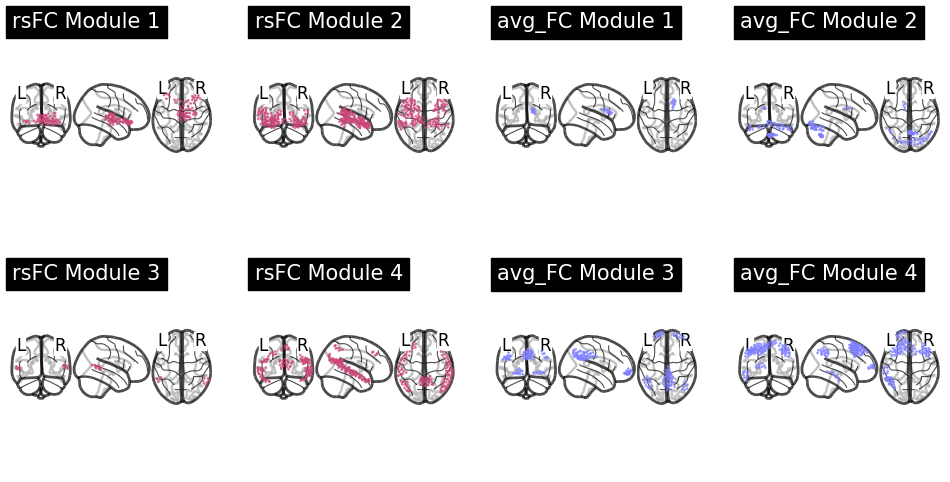

In [18]:
# 1-4
plot_brain_modules(MNI_coords, rsFC_labels, avgrsFC_labels, 
                  module_range=(1, 5),
                  rsFC_cmap="plasma",
                  avgFC_cmap="cool", 
                  output_filename='plot_files/modules_1-4.png')

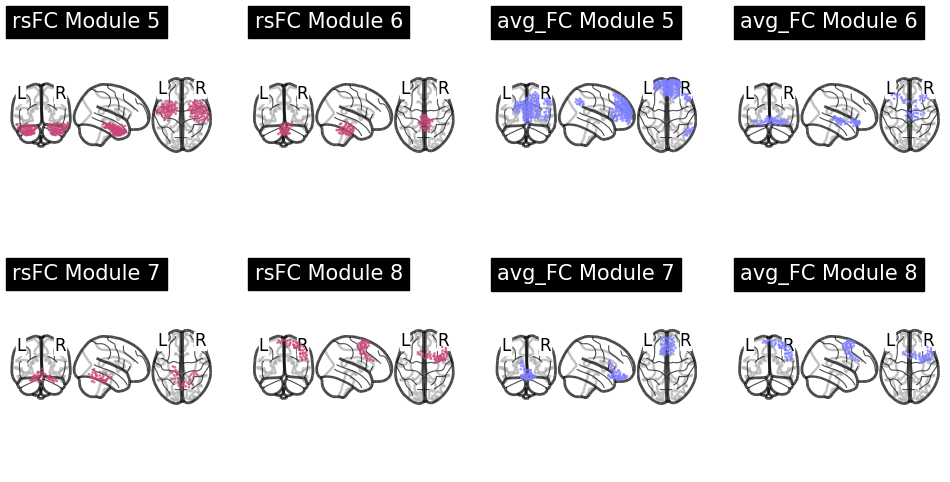

In [19]:
# 5-8
plot_brain_modules(MNI_coords, rsFC_labels, avgrsFC_labels, 
                  module_range=(5, 9),
                  rsFC_cmap="plasma",
                  avgFC_cmap="cool", 
                  output_filename='plot_files/modules_5-8.png')

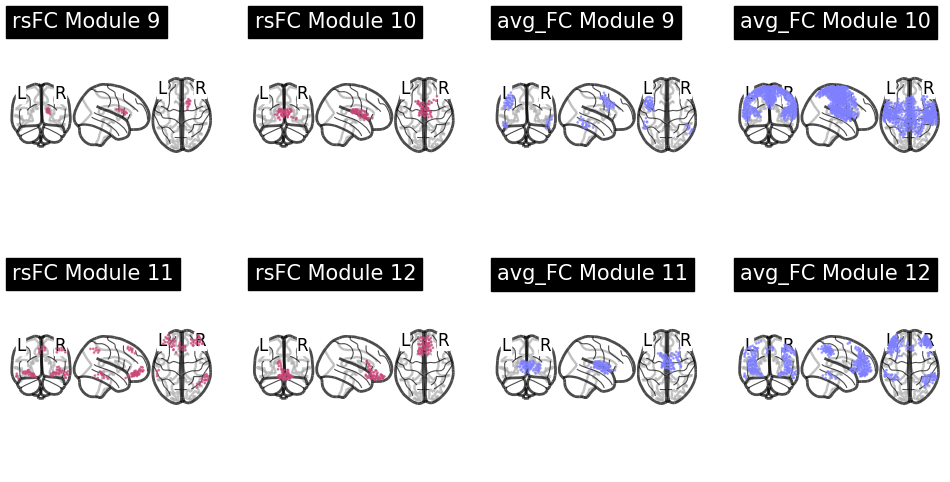

In [20]:
# 9-12
plot_brain_modules(MNI_coords, rsFC_labels, avgrsFC_labels, 
                  module_range=(9, 13),
                  rsFC_cmap="plasma",
                  avgFC_cmap="cool", 
                  output_filename='plot_files/modules_9-12.png')

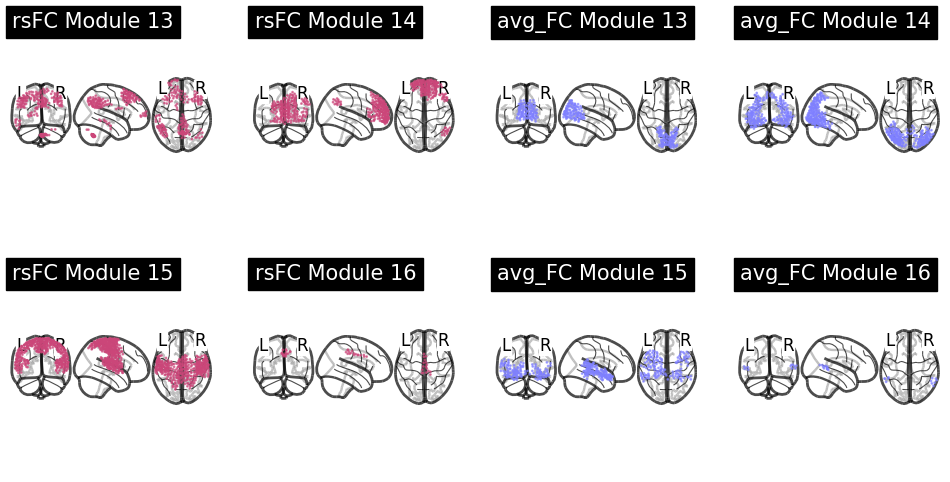

In [21]:
# 13-16
plot_brain_modules(MNI_coords, rsFC_labels, avgrsFC_labels, 
                  module_range=(13, 17),
                  rsFC_cmap="plasma",
                  avgFC_cmap="cool", 
                  output_filename='plot_files/modules_13-16.png')

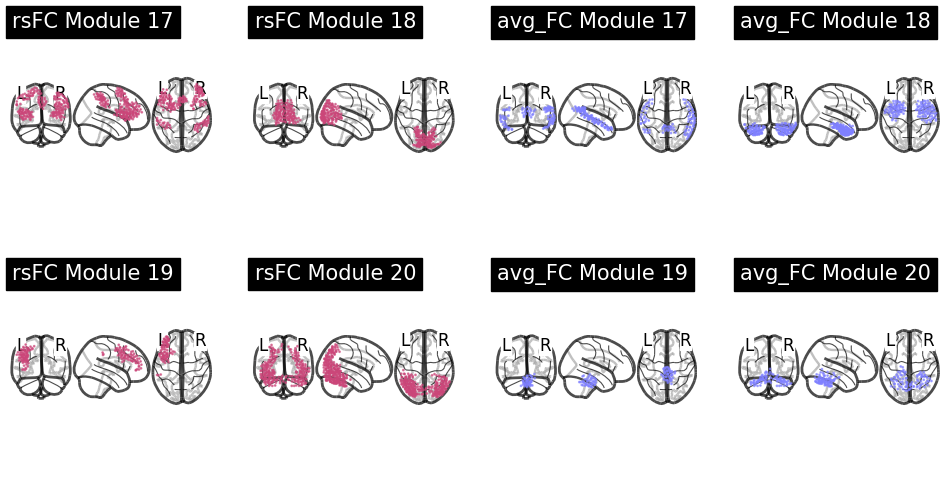

In [22]:
# 17-20
plot_brain_modules(MNI_coords, rsFC_labels, avgrsFC_labels, 
                  module_range=(17, 21),
                  rsFC_cmap="plasma",
                  avgFC_cmap="cool", 
                  output_filename='plot_files/modules_17-20.png')

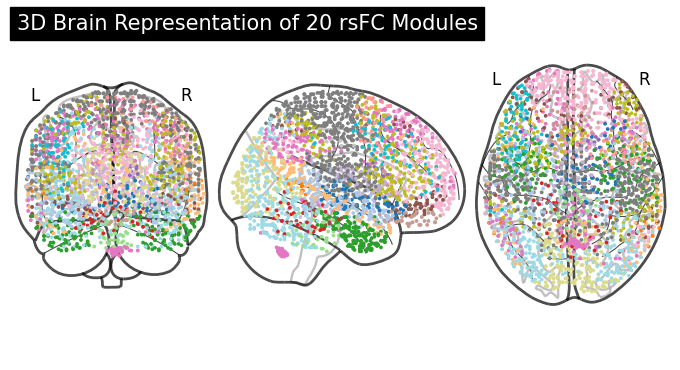

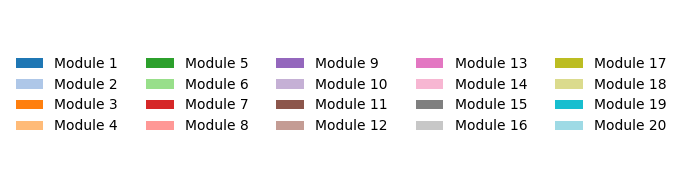

In [27]:
# Normalize module labels to 0–19 for colormap indexing
module_ids = rsFC_labels - 1

# Get colormap with 20 distinct colors
cmap = get_cmap('tab20')  # 20 different colors
node_colors = np.array([cmap(i) for i in module_ids])[:, :3]  # RGB colors only

# Dummy connectivity matrix (all zeros)
n_nodes = MNI_coords.shape[0]
connectivity_matrix = np.zeros((n_nodes, n_nodes))

# Plot brain with colored nodes
plotting.plot_connectome(connectivity_matrix, MNI_coords,
                         node_color=node_colors,
                         node_size=3,
                         edge_threshold=None,
                         display_mode='ortho',
                         title='3D Brain Representation of 20 rsFC Modules')

# --- Add legend ---
# Create color patches for legend
legend_elements = [Patch(facecolor=cmap(i), edgecolor='none', label=f'Module {i+1}')
                   for i in range(20)]

# Show legend in a separate matplotlib figure (Nilearn doesn't support direct legend placement)
fig_legend = plt.figure(figsize=(6, 2))
plt.legend(handles=legend_elements, loc='center', ncol=5, frameon=False)
plt.axis('off')
plt.tight_layout()
plt.show()

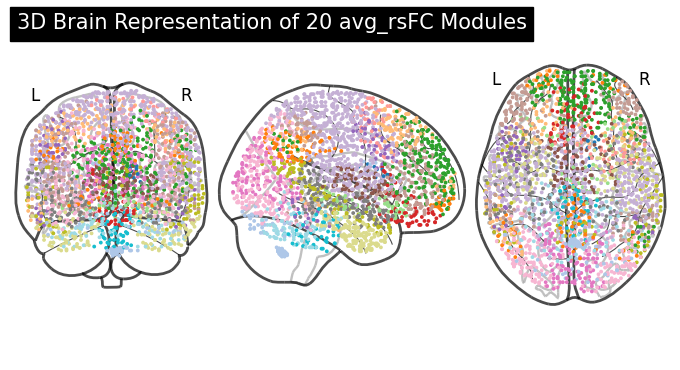

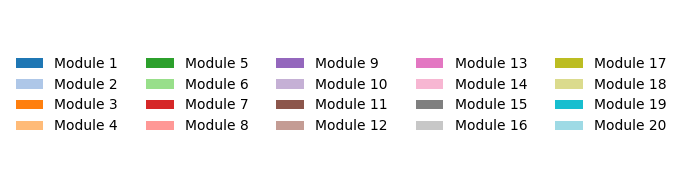

In [28]:
# Normalize module labels to 0–19 for colormap indexing
module_ids = avgrsFC_labels - 1

# Get colormap with 20 distinct colors
cmap = get_cmap('tab20')  # 20 different colors
node_colors = np.array([cmap(i) for i in module_ids])[:, :3]  # RGB colors only

# Dummy connectivity matrix (all zeros)
n_nodes = MNI_coords.shape[0]
connectivity_matrix = np.zeros((n_nodes, n_nodes))

# Plot brain with colored nodes
plotting.plot_connectome(connectivity_matrix, MNI_coords,
                         node_color=node_colors,
                         node_size=3,
                         edge_threshold=None,
                         display_mode='ortho',
                         title='3D Brain Representation of 20 avg_rsFC Modules')

# --- Add legend ---
# Create color patches for legend
legend_elements = [Patch(facecolor=cmap(i), edgecolor='none', label=f'Module {i+1}')
                   for i in range(20)]

# Show legend in a separate matplotlib figure (Nilearn doesn't support direct legend placement)
fig_legend = plt.figure(figsize=(6, 2))
plt.legend(handles=legend_elements, loc='center', ncol=5, frameon=False)
plt.axis('off')
plt.tight_layout()
plt.show()
